# Clustering on multi-joint coordination to identify coordination patterns in pitching and their effect on elbow varus torque and pitch speed

The pourpose of this analysis was to investigate 1) if baseball pitchers can be devided into groups based on inter-joint coordination patterns and 2) the difference between groups in terms of pitch speed and elbow varus torque. <br /> 
We used data from [the OpenBiomechanics Project](https://github.com/drivelineresearch/openbiomechanics)

In [510]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import time
from scipy.signal import resample
import seaborn as sns

In [511]:
def segment_resample(data:pd.DataFrame, session:str, n_pitch:int, del_df:list) -> pd.DataFrame:
    """
    This is a functions to generate a resampled data
    from foot contact to ball release with 101 data points
    The function returns a data frame that is resampled for the subsequent analysis
    """
    
    # get data by session for a pitcher
    df_by_pitch = data[data["session_pitch"] == session].reset_index()

    # segment from foot contact to ball release
    fc_time = df_by_pitch["fp_10_time"].unique()
    fc_inx = df_by_pitch[df_by_pitch["time"] == fc_time[0]].index

    br_time = df_by_pitch["BR_time"].unique()
    br_inx = df_by_pitch[df_by_pitch["time"] == br_time[0]].index

    # check if trial has valid events
    # if not, return the original data frame
    if fc_inx.empty:
        print(f"{id}: trial {n_pitch + 1} invalid trial: foot contact not defined")
        del_df.append(n_pitch)
        return df_by_pitch
    elif br_inx.empty:
        print(f"{id}: trial {n_pitch + 1} invalid trial: ball release not defined")
        del_df.append(n_pitch)
        return df_by_pitch
    elif fc_inx > br_inx:
        print(f"{id}: trial {n_pitch + 1} invalid trial: the order of events error (ball release to foot contact)")
        del_df.append(n_pitch)
        return df_by_pitch

    # segment data form foot contact to ball release
    segmented_df = df_by_pitch[fc_inx[0]:br_inx[0]].copy()

    # fill nan
    segmented_df.ffill().bfill()

    # get columns name
    current_colmuns = segmented_df.columns

    # resample it to 101 data points
    resampled_segmented_data = pd.DataFrame(resample(segmented_df, 101),
                                                columns=current_colmuns)

    # dorop unnecessary columns for the subsequent analysis
    # the data frame aftre this process should have only velocity data
    '''
    resampled_segmented_data.drop(columns=["index",
                                            "session_pitch",
                                            "time",
                                            "pkh_time",
                                            "fp_10_time",
                                            "fp_100_time",
                                            "MER_time",
                                            "MIR_time",
                                            "BR_time"], inplace=True)
    '''

    variables = ["lead_knee_velo_x",
                 "pelvis_velo_x",
                 "pelvis_velo_y",
                 "pelvis_velo_z",
                 "torso_velo_x",
                 "torso_velo_y",
                 "torso_velo_z",
                 "shoulder_velo_x",
                 "shoulder_velo_y",
                 "shoulder_velo_z",
                 "elbow_velo_x",
                 "elbow_velo_z",
                 "wrist_velo_x",
                 "wrist_velo_y"]

    resampled_segmented_data = resampled_segmented_data[variables]

    return resampled_segmented_data

## Import Data set 

In [512]:
# absolute path to the data
path = "/home/yyanagita/data/motion_classification/joint_velos.csv"

# import data to pandas data frame
df_joint_velocity = pd.read_csv(path)

In [513]:
# display first 5 rows
df_joint_velocity.head()

,session_pitch,time,elbow_velo_x,elbow_velo_y,elbow_velo_z,rear_hip_velo_x,rear_hip_velo_y,rear_hip_velo_z,rear_knee_velo_x,rear_knee_velo_y,...,torso_velo_z,torso_pelvis_velo_x,torso_pelvis_velo_y,torso_pelvis_velo_z,pkh_time,fp_10_time,fp_100_time,MER_time,BR_time,MIR_time
0,1031_2,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
1,1031_2,0.0028,268.0558,-1081.1728,-132.3921,-60.9899,-170.2306,388.7123,-124.3655,-2.1518,...,-23.3659,22.0803,3.9685,5.0452,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
2,1031_2,0.0056,208.5674,-843.5846,-103.2996,-55.0698,-131.7576,310.0950,-99.1835,-1.6739,...,-24.2806,21.6278,3.5474,5.0219,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
3,1031_2,0.0083,151.5794,-617.1972,-75.5779,-49.4129,-94.9223,235.0877,-75.1388,-1.2168,...,-25.2296,21.2070,3.0799,5.0817,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
4,1031_2,0.0111,99.4751,-411.3320,-50.3682,-44.2690,-61.2806,166.8601,-53.2711,-0.7995,...,-26.2045,20.8405,2.5554,5.2453,0.625,1.1806,1.1917,1.3056,1.3389,1.3778


In [514]:
# import point matrix (descret point data)
path = "/home/yyanagita/data/motion_classification/poi_metrics.csv"
df_point = pd.read_csv(path)

In [515]:
# display first 5 rows
df_point.head()

,session_pitch,session,p_throws,pitch_type,pitch_speed_mph,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,...,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,1031_2,1031,R,FF,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,...,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,1031_3,1031,R,FF,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,...,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,1097_1,1097,R,FF,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,...,1094.7686,1283.0751,58.3164,957.3923,245.4411,1767.4604,2010.5341,61.5594,4.4432,52.9333
3,1097_2,1097,R,FF,77.0,3832.1715,2424.0493,1105.2275,27.9286,124.6578,...,1187.5810,1354.7150,58.7397,860.3796,280.5177,1715.1864,1864.0488,66.6789,6.4897,54.3727
4,1097_3,1097,R,FF,76.1,3970.7971,2497.6253,1110.4850,28.9909,124.8308,...,1214.0065,1425.2124,58.0297,1066.6047,337.4227,2120.4510,2283.1749,65.9014,7.2019,106.2719


In [516]:
# import meta data
path = "/home/yyanagita/data/motion_classification/metadata.csv"
df_meta = pd.read_csv(path)

In [517]:
# display first 5 rows
df_meta.head()

,user,session,session_pitch,session_mass_kg,session_height_m,age_yrs,playing_level,pitch_speed_mph,filename_new,modelname_new
0,750,1031,1031_2,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_013_FF_904.c3d,000750_001031_model.c3d
1,750,1031,1031_3,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_014_FF_904.c3d,000750_001031_model.c3d
2,774,1097,1097_1,101.1528,1.9304,19.41,college,77.6,000774_001097_76_223_001_FF_776.c3d,000774_001097_model.c3d
3,774,1097,1097_2,101.1528,1.9304,19.41,college,77.0,000774_001097_76_223_005_FF_770.c3d,000774_001097_model.c3d
4,774,1097,1097_3,101.1528,1.9304,19.41,college,76.1,000774_001097_76_223_006_FF_761.c3d,000774_001097_model.c3d


## Characteristics of players

/tmp/ipykernel_4195/3361738632.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["College", "Independent", "MLB", "High School"], fontsize=10)


[Text(0, 0, 'College'),
 Text(1, 0, 'Independent'),
 Text(2, 0, 'MLB'),
 Text(3, 0, 'High School')]

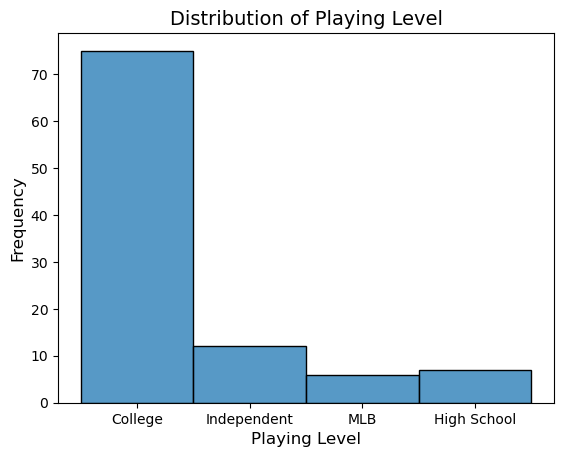

In [518]:
fig, ax = plt.subplots()

x = df_meta.drop_duplicates("session")
x = x["playing_level"]

sns.histplot(x, ax=ax)
ax.set_xlabel("Playing Level", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Distribution of Playing Level", fontsize=14)
ax.set_xticklabels(["College", "Independent", "MLB", "High School"], fontsize=10)

Because of the honmogeneity of playing level in the data set, we forcused on analyzing college players to ensure enough sampls when clustering. We only used right-handed pitcher because left-handed pitcher would creat their own cluster by handness. 

In [519]:
# add throwing arm ("R" right handed for and "L" for left handed) from poi_metrics.csv"
df_meta["p_throw"] = df_point["p_throws"]

In [520]:
# select college level and right handed pitchers from the data set
df_meta = df_meta[(df_meta["playing_level"] == "college") & (df_meta["p_throw"] == "R")]

In [573]:
sessions = df_meta["session"]

### Demographics

In [521]:
df_meta.describe()[["age_yrs", "session_height_m", "session_height_m", "pitch_speed_mph"]]

,age_yrs,session_height_m,session_height_m,pitch_speed_mph
count,256.000000,256.000000,256.000000,256.000000
mean,20.797344,1.842591,1.842591,84.883594
std,1.487967,0.067774,0.067774,4.385856
min,18.620000,1.676400,1.676400,72.600000
25%,19.610000,1.803400,1.803400,82.475000
50%,20.540000,1.854200,1.854200,85.350000
75%,21.570000,1.879600,1.879600,87.800000
max,24.430000,2.006600,2.006600,94.400000


## Data Cleaning

In [522]:
# get unique pitch ID
unique_sessions = [i for i in df_meta["session"].unique()]

# print unique pitch ID and number of pitchers included in this study
print(f"Unique ID: {unique_sessions}")
print(f"Number of participants: {len(unique_sessions)}")

Unique ID: [1031, 1097, 1170, 1313, 1346, 1403, 1562, 1574, 1581, 1601, 1612, 1615, 1623, 1668, 1759, 1783, 1826, 1830, 1845, 2653, 2730, 2734, 2742, 2760, 2761, 2815, 2818, 2833, 2843, 2853, 2857, 2859, 2860, 2861, 2865, 2882, 2889, 2907, 2916, 2919, 2923, 2927, 2935, 2965, 2979, 2981, 2993, 3034, 3035, 3043, 3046, 3055, 3065, 3140, 3222, 3232, 3233, 3247, 3248, 3252]
Number of participants: 60


In [523]:
# get unique trial
unique_trials = [i for i in df_point["session_pitch"].unique()]

# print unique trial and total number of trials
print(f"Unique ID: {unique_trials}")
print(f"Number of trials in the data set: {len(unique_trials)}")

Unique ID: ['1031_2', '1031_3', '1097_1', '1097_2', '1097_3', '1170_1', '1170_2', '1250_1', '1250_3', '1313_1', '1313_2', '1313_3', '1346_1', '1346_2', '1346_3', '1370_1', '1370_2', '1370_3', '1371_2', '1371_3', '1393_1', '1393_2', '1393_3', '1394_1', '1394_2', '1394_3', '1403_1', '1403_2', '1403_3', '1561_1', '1561_2', '1561_3', '1562_1', '1562_2', '1562_3', '1574_1', '1574_2', '1574_3', '1581_1', '1581_2', '1581_3', '1601_1', '1601_2', '1601_3', '1603_1', '1603_2', '1603_3', '1612_1', '1612_2', '1612_3', '1615_1', '1615_2', '1620_1', '1620_3', '1623_1', '1623_2', '1623_3', '1665_1', '1665_2', '1665_3', '1668_1', '1668_2', '1668_3', '1688_1', '1688_2', '1717_1', '1717_3', '1718_1', '1718_2', '1718_3', '1729_1', '1729_2', '1729_3', '1759_1', '1759_2', '1759_3', '1778_1', '1778_2', '1779_1', '1779_2', '1779_3', '1782_1', '1782_2', '1782_3', '1782_4', '1783_2', '1783_3', '1783_4', '1783_5', '1808_1', '1808_2', '1808_3', '1808_4', '1808_5', '1826_1', '1826_2', '1826_3', '1826_4', '1826_5'

In [524]:
# get number of trials for each pitcher 
n_trials_by_pitcher = df_meta.groupby("session")["session"].count()

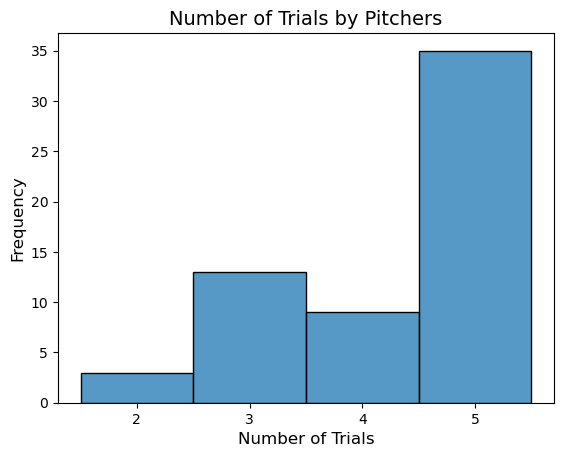

In [525]:
fig, ax = plt.subplots()

sns.histplot(n_trials_by_pitcher,
             discrete=True)

ax.set_title("Number of Trials by Pitchers", fontsize=14)
ax.set_xlabel("Number of Trials", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xticks([2, 3, 4, 5])

Some pitchers pitched two and most of others pitched five trials

## Compute similarity and create data set for clustering

In [526]:
clustering_data = pd.DataFrame()

for id in unique_sessions:

    print(f"processing: {id}")
    # instanciate an empty list that will contain invalid trials
    del_df = []

    id = id.astype("str")
    # data by a pithcer
    df_by_id = df_joint_velocity[df_joint_velocity["session_pitch"].str.contains(id)]
    df_by_id.isna().sum()

    # get unique session 
    unique_sessions_by_pitcher = df_by_id["session_pitch"].unique()
    print(f"unique sessions: {unique_sessions_by_pitcher}")

    # create col names by nubmer of pitches
    n_pitchs = len(unique_sessions_by_pitcher)
    print(f'Number of trials: {n_pitchs}')

    # create empty dataframes basebd on number of trials for later averaging them
    dfs = [pd.DataFrame() for _ in range(n_pitchs)]
    print(f"number of trials: {n_pitchs}")
    print(f"data length: {len(dfs)}")

    # iterate through trials within a sigle pitcher and get average of trials
    for session, n_pitch in zip(unique_sessions_by_pitcher, range(n_pitchs)):

        print(f"processing: {session}, trial: {n_pitch + 1}")

        dfs[n_pitch] = segment_resample(df_by_id, session, n_pitch, del_df) # this returns dataframe with 101 rows

        # when the final trial is done 
        if n_pitch +1 == n_pitchs:

            if len(del_df) > 0:

                # Sort indices in reverse order to avoid index shifting issues
                del_df.sort(reverse=True)
                for i in del_df:
                    del dfs[i]

            # Compute the average across them
            corr_data = sum(dfs) / len(dfs)

            # Compute cosine similarity between all rows
            correlation_series = cosine_similarity(corr_data.T)

            upper_triangle = np.triu(correlation_series, k=1)
            unique_corr = upper_triangle[upper_triangle != 0]
            print(f"a feature vector shape: {unique_corr.shape}")
            df = pd.DataFrame(unique_corr)
            clustering_data = pd.concat([clustering_data, df], axis=1)


processing: 1031
unique sessions: ['1031_2' '1031_3']
Number of trials: 2
number of trials: 2
data length: 2
processing: 1031_2, trial: 1
processing: 1031_3, trial: 2
a feature vector shape: (91,)
processing: 1097
unique sessions: ['1097_1' '1097_2' '1097_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1097_1, trial: 1
processing: 1097_2, trial: 2
processing: 1097_3, trial: 3
a feature vector shape: (91,)
processing: 1170
unique sessions: ['1170_1' '1170_2']
Number of trials: 2
number of trials: 2
data length: 2
processing: 1170_1, trial: 1
processing: 1170_2, trial: 2
a feature vector shape: (91,)
processing: 1313
unique sessions: ['1313_1' '1313_2' '1313_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1313_1, trial: 1
processing: 1313_2, trial: 2
processing: 1313_3, trial: 3
a feature vector shape: (91,)
processing: 1346
unique sessions: ['1346_1' '1346_2' '1346_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1346_1

In [527]:
print(f"original data shape: {clustering_data.shape}")
clustering_data = clustering_data.T # transpose data
print(f"data shape after transporsed: {clustering_data.shape}")

original data shape: (91, 60)
data shape after transporsed: (60, 91)


## Hierachical Clustering

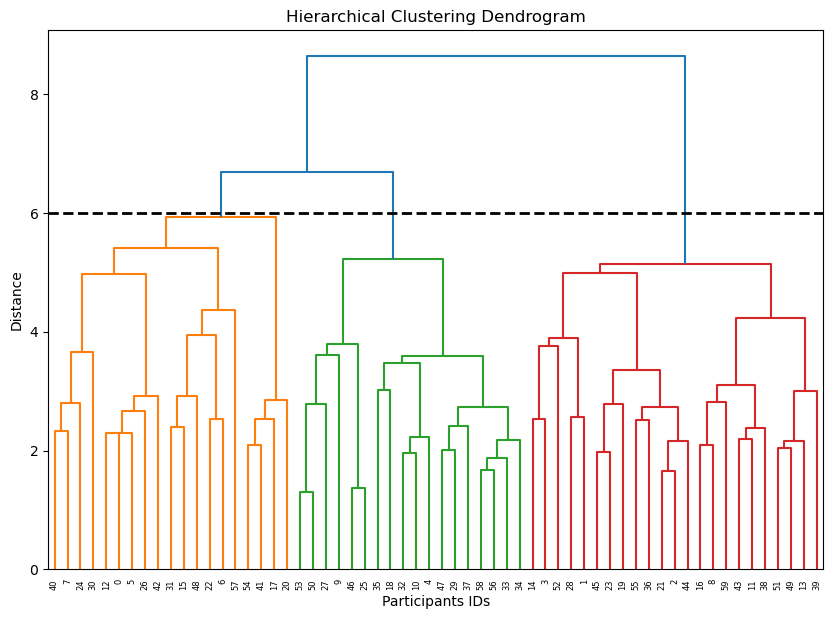

In [528]:
# clustering
from scipy.cluster.hierarchy import dendrogram, linkage
# Perform hierarchical clustering using Ward's method and Euclidean distance
#linked = linkage(df_clustering_data, method='ward', metric='euclidean')
#linked = linkage(transformed_clustering_data, method='ward', metric='euclidean')
linked = linkage(clustering_data, method='ward', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           color_threshold=6)
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(6, color='k', linestyle='--', linewidth=2)
plt.xlabel('Participants IDs')
plt.ylabel('Distance')
plt.show()

In [529]:
from scipy.cluster.hierarchy import fcluster

# set distance to cut the dendrogram
max_d = 6

# get clusters
clusters = fcluster(linked, max_d, criterion='distance')

# get ids for pitchers
# ids = df_clustering_data.index
# ids = unique_sessions

# create and empty data frame 
df_clustering_results = pd.DataFrame(columns=["session", "clusters"])


In [530]:
# fill the data frame with ids and clusters
df_clustering_results["session"] = unique_sessions
df_clustering_results["clusters"] = clusters

df_clustering_results

,session,clusters
0,1031,3
1,1097,1
2,1170,1
3,1313,1
4,1346,2
5,1403,3
6,1562,3
7,1574,3
8,1581,1
9,1601,2


## PCA in 3D representation

In [531]:
pca = PCA(n_components=3) 
transformed_clustering_data = pca.fit_transform(clustering_data)
df_clustering_data = pd.DataFrame(transformed_clustering_data, columns=["PC1", "PC2", "PC3"])
#df_clustering_data["session"] = unique_sessions
#df_clustering_data.set_index("session")

Text(0.5, 0, 'PC3')

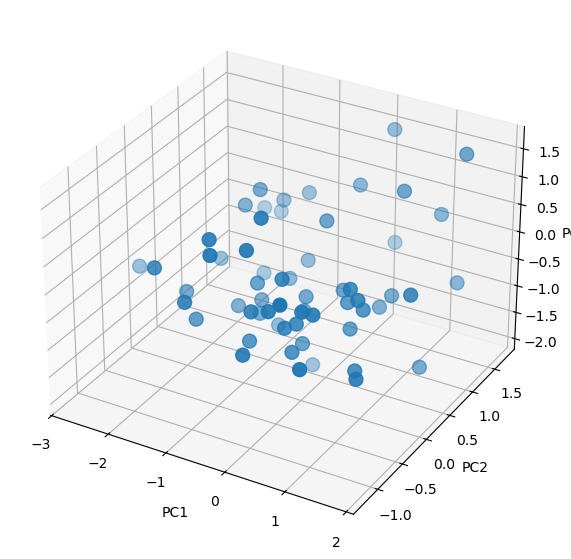

In [532]:
# visualize PCs 
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

ax.scatter(df_clustering_data["PC1"],
           df_clustering_data["PC2"],
           df_clustering_data["PC3"],
           s=100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


## Marge dataframes

In [533]:
average_pitch_speed_by_pitchers = df_meta.groupby("session")["pitch_speed_mph"].mean().reset_index()
average_pitch_speed_by_pitchers

,session,pitch_speed_mph
0,1031,90.400000
1,1097,76.900000
2,1170,81.750000
3,1313,85.833333
4,1346,84.633333
5,1403,78.400000
6,1562,90.900000
7,1574,89.300000
8,1581,82.533333
9,1601,86.200000


In [566]:
df_meta = df_meta.drop_duplicates(subset="session")[["session", "session_mass_kg", "session_height_m", "age_yrs", "playing_level", "p_throw", "pitch_speed_mph"]].reset_index()
df_meta["pitch_speed_mph"] = average_pitch_speed_by_pitchers["pitch_speed_mph"]

In [567]:
df_clustering_results["session"] = df_clustering_results["session"].astype("int")
df_merged = pd.merge(df_clustering_results, df_meta, left_on="session", right_on="session")

In [568]:
elbow_varus_moment = df_point.groupby("session", as_index=False)["elbow_varus_moment"].mean()
df_merged = pd.merge(df_merged, elbow_varus_moment, left_on="session", right_on="session")

In [569]:
df_merged

,session,clusters,index,session_mass_kg,session_height_m,age_yrs,playing_level,p_throw,pitch_speed_mph,elbow_varus_moment
0,1031,3,0,110.6784,1.9304,21.40,college,R,90.400000,142.860150
1,1097,1,1,101.1528,1.9304,19.41,college,R,76.900000,132.920900
2,1170,1,2,82.1016,1.9304,20.52,college,R,81.750000,99.863650
3,1313,1,3,84.3696,1.8288,19.02,college,R,85.833333,129.460833
4,1346,2,4,72.1224,1.8288,20.67,college,R,84.633333,84.773267
5,1403,3,5,70.3080,1.7780,19.10,college,R,78.400000,73.512367
6,1562,3,6,95.7096,1.8542,20.81,college,R,90.900000,119.651667
7,1574,3,7,87.0912,1.9304,21.22,college,R,89.300000,93.158567
8,1581,1,8,94.8024,1.7018,21.51,college,R,82.533333,118.285400
9,1601,2,9,103.8744,1.8542,20.87,college,R,86.200000,135.216700


In [570]:
# export as csv 
df_merged.to_csv("pitching_motion_clustering_comparison_datasets.csv")

## Visualization by clustered groups

Text(0.5, 0, 'PC3')

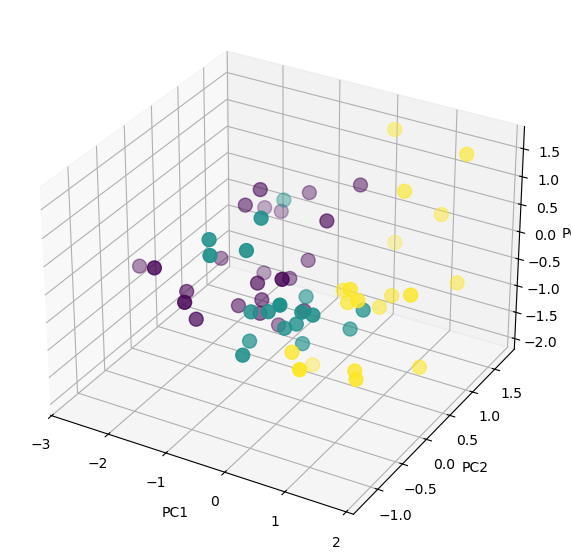

In [539]:
# visualize PCs  
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

ax.scatter(df_clustering_data["PC1"],
           df_clustering_data["PC2"],
           df_clustering_data["PC3"],
           s=100,
           c=df_merged["clusters"], cmap='viridis'
           )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [540]:
# Calcurate petch seed mean and SD by clustered groups
mean = df_merged.groupby("clusters")["pitch_speed_mph"].mean()
print(f"Mean pitch_speed_mph by cluster: {mean} ")
sd = df_merged.groupby("clusters")["pitch_speed_mph"].std()
print(f"SD pitch_speed_mpht by cluster: {sd} ")

Mean pitch_speed_mph by cluster: clusters
1    84.843478
2    85.972222
3    84.426316
Name: pitch_speed_mph, dtype: float64 
SD pitch_speed_mpht by cluster: clusters
1    4.029305
2    3.387313
3    5.560160
Name: pitch_speed_mph, dtype: float64 


In [541]:
# Calcurate elbow valgus torque mean and SD by clustered groups
mean = df_merged.groupby("clusters")["elbow_varus_moment"].mean()
print(f"Mean elbow varus moment by cluster: {mean} ")
sd = df_merged.groupby("clusters")["elbow_varus_moment"].std()
print(f"SD elbow varus moment by cluster: {sd} ")

Mean elbow varus moment by cluster: clusters
1    116.451585
2    103.735925
3    105.327563
Name: elbow_varus_moment, dtype: float64 
SD elbow varus moment by cluster: clusters
1    15.084151
2    15.287242
3    17.610035
Name: elbow_varus_moment, dtype: float64 


/tmp/ipykernel_4195/558373054.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x=df_merged["clusters"],


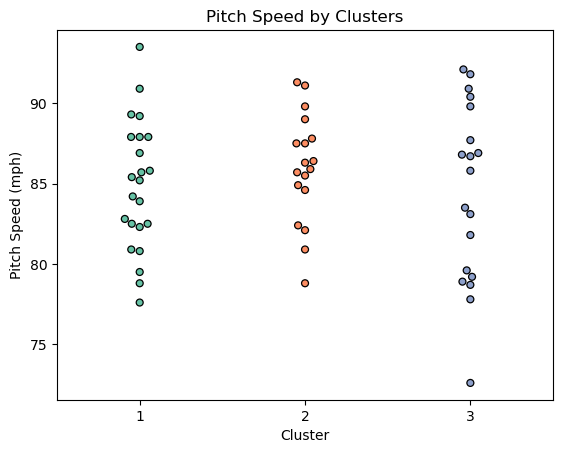

In [542]:
# plot pitch speed by clusters
import seaborn as sns
fig, ax = plt.subplots()

sns.swarmplot(x=df_merged["clusters"],
              y=df_merged["pitch_speed_mph"],
              ax=ax,
              palette='Set2', # Point color
              edgecolor='black', # Edge color
              linewidth=0.9, # Edge size
                )

plt.xlabel('Cluster')
plt.ylabel('Pitch Speed (mph)')
plt.title("Pitch Speed by Clusters")
plt.show()

/tmp/ipykernel_4195/3321239714.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x=df_merged["clusters"],


<Axes: xlabel='clusters', ylabel='elbow_varus_moment'>

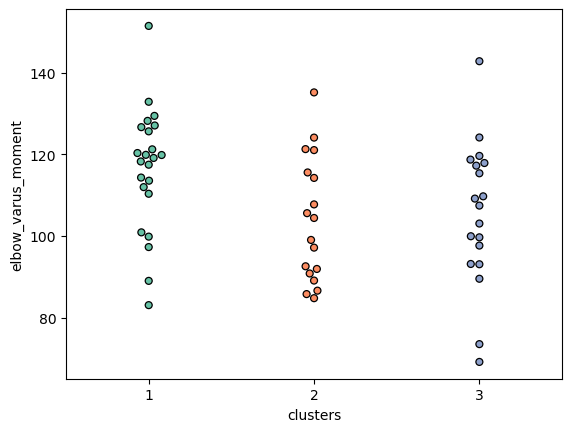

In [543]:
# plot elbow valgus torque by clusters
import seaborn as sns
fig, ax = plt.subplots()

sns.swarmplot(x=df_merged["clusters"],
              y=df_merged["elbow_varus_moment"],
              ax=ax,
              palette='Set2', # Point color
              edgecolor='black', # Edge color
              linewidth=0.9, # Edge size
                )


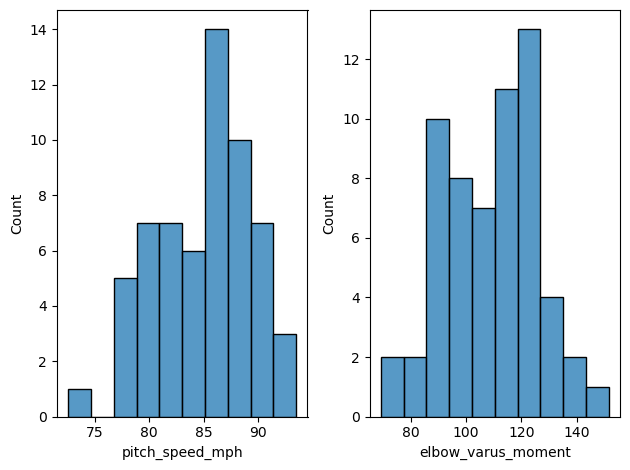

In [544]:
# distribution of two dependent variables
fig, axs = plt.subplots(1, 2, tight_layout=True)

sns.histplot(data=df_merged, x="pitch_speed_mph", ax=axs[0], bins=10)
sns.histplot(data=df_merged, x="elbow_varus_moment", ax=axs[1], bins=10)
plt.show()

### MANCOVA

In [545]:
from statsmodels.multivariate.manova import MANOVA

# Fit the model
manova = MANOVA.from_formula("elbow_varus_moment + pitch_speed_mph ~ C(clusters) + session_mass_kg + session_height_m + age_yrs", data=df_merged)
print(manova.mv_test())

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9448 2.0000 53.0000  1.5469 0.2224
          Pillai's trace 0.0552 2.0000 53.0000  1.5469 0.2224
  Hotelling-Lawley trace 0.0584 2.0000 53.0000  1.5469 0.2224
     Roy's greatest root 0.0584 2.0000 53.0000  1.5469 0.2224
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
      C(clusters)       Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.7768 4.0000 106.0000  3.5672 0.0090
         Pillai's trace 0.2267 4.0000 108.0000  3.4516 0.0107
 Hotelling-Lawley trace 0.

### Generalized Linear Model

In [546]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# interactiion effects
model = smf.ols("pitch_speed_mph ~ elbow_varus_moment * C(clusters) + session_mass_kg + session_height_m + age_yrs", data=df_merged)
results = model.fit()

# Print the model summary, which includes fixed effects estimates and p-values
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        pitch_speed_mph   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     3.858
Date:                Mon, 15 Sep 2025   Prob (F-statistic):            0.00129
Time:                        23:43:04   Log-Likelihood:                -159.07
No. Observations:                  60   AIC:                             336.1
Df Residuals:                      51   BIC:                             355.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

/tmp/ipykernel_4195/1672535922.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_merged[df_merged['clusters'] == 1],
/tmp/ipykernel_4195/1672535922.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_merged[df_merged['clusters'] == 2],
/tmp/ipykernel_4195/1672535922.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_merged[df_merged['clusters'] == 3],


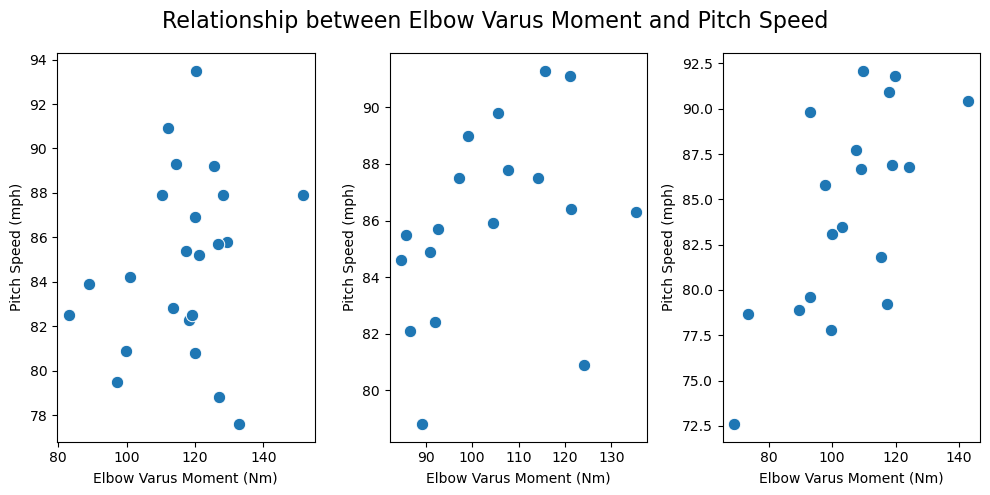

In [547]:
# plot the relationship between elbow torque and pitch speed by clusters
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]

fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(10, 5))
sns.scatterplot(data=df_merged[df_merged['clusters'] == 1],
                x="elbow_varus_moment",
                y="pitch_speed_mph", 
                palette=custom_palette,
                s=80,
                ax=axs[0])

# Add axis labels
axs[0].set_xlabel("Elbow Varus Moment (Nm)")
axs[0].set_ylabel("Pitch Speed (mph)")



sns.scatterplot(data=df_merged[df_merged['clusters'] == 2],
                x="elbow_varus_moment",
                y="pitch_speed_mph", 
                palette=custom_palette,
                s=80,
                ax=axs[1])

# Add axis labels
axs[1].set_xlabel("Elbow Varus Moment (Nm)")
axs[1].set_ylabel("Pitch Speed (mph)")


sns.scatterplot(data=df_merged[df_merged['clusters'] == 3],
                x="elbow_varus_moment",
                y="pitch_speed_mph", 
                palette=custom_palette,
                s=80,
                ax=axs[2])


# Add axis labels
axs[2].set_xlabel("Elbow Varus Moment (Nm)")
axs[2].set_ylabel("Pitch Speed (mph)")

# Add an overall title to the figure
plt.suptitle("Relationship between Elbow Varus Moment and Pitch Speed", fontsize=16)

plt.tight_layout()
plt.show()

### Feature selection

In [548]:
# Get upper triangle indices (excluding diagonal)
n = correlation_series.shape[0]
upper_indices = np.triu_indices(n, k=1)

# Step 3: Extract unique similarity values
unique_corr = correlation_series[upper_indices]

# Step 4: Create labels for each pair
cols = corr_data.columns
labels = [f"{cols[i]}_{cols[j]}" for i, j in zip(*upper_indices)]

df_feature_selection = clustering_data
df_feature_selection.columns = labels

df_feature_selection["session"] = df_merged["session"].values
df_feature_selection["clusters"] = df_merged["clusters"].values

df_feature_selection

,lead_knee_velo_x_pelvis_velo_x,lead_knee_velo_x_pelvis_velo_y,lead_knee_velo_x_pelvis_velo_z,lead_knee_velo_x_torso_velo_x,lead_knee_velo_x_torso_velo_y,lead_knee_velo_x_torso_velo_z,lead_knee_velo_x_shoulder_velo_x,lead_knee_velo_x_shoulder_velo_y,lead_knee_velo_x_shoulder_velo_z,lead_knee_velo_x_elbow_velo_x,...,shoulder_velo_z_wrist_velo_x,shoulder_velo_z_wrist_velo_y,elbow_velo_x_elbow_velo_z,elbow_velo_x_wrist_velo_x,elbow_velo_x_wrist_velo_y,elbow_velo_z_wrist_velo_x,elbow_velo_z_wrist_velo_y,wrist_velo_x_wrist_velo_y,session,clusters
0,0.048794,0.009455,0.287383,-0.399414,0.173765,0.326263,0.021156,0.136201,0.366363,0.378165,...,-0.864026,-0.351884,0.020153,-0.824426,-0.290773,-0.354737,0.089639,0.511308,1031,3
0,0.676589,0.294226,0.376083,-0.445564,0.221762,0.504478,-0.256072,0.441556,0.152101,0.676441,...,-0.938446,-0.622314,-0.140554,-0.605771,-0.004098,0.075553,0.569656,0.488074,1097,1
0,0.352461,0.165368,0.148608,-0.351566,0.214969,0.276457,-0.044693,0.089660,0.286055,0.440945,...,-0.809569,-0.396819,-0.456261,-0.815262,0.438975,0.518009,-0.130301,-0.023049,1170,1
0,0.533129,-0.176983,-0.096374,-0.784569,-0.371079,0.205672,-0.418647,0.545113,0.319049,0.593531,...,-0.912609,-0.293380,-0.090152,-0.383500,0.580011,-0.004904,0.334414,0.314956,1313,1
0,0.682504,0.269275,0.425076,-0.498888,0.428508,0.666871,-0.436758,0.586686,-0.208013,0.538437,...,-0.903324,-0.238758,0.156448,-0.675891,0.254485,-0.172494,0.422562,0.121066,1346,2
0,0.042849,0.131406,0.089195,-0.711510,0.068676,0.167035,-0.168335,-0.188742,0.465950,0.596448,...,-0.940083,-0.459161,0.150986,-0.683002,-0.392315,-0.641107,-0.372919,0.555530,1403,3
0,-0.166635,-0.312699,-0.274663,0.118794,-0.488313,-0.354594,0.444768,-0.037932,0.089885,-0.122649,...,-0.856617,0.661895,0.201706,-0.671809,0.455546,-0.566188,0.722375,-0.390442,1562,3
0,-0.267862,-0.497901,-0.482661,-0.693451,-0.628335,-0.350235,0.049151,-0.302373,0.675171,0.295765,...,-0.731882,0.014082,0.249151,-0.767078,0.695003,-0.687379,0.504551,-0.538048,1574,3
0,0.485496,0.323301,0.433672,-0.117216,-0.013907,0.471772,-0.383007,-0.186087,0.039467,0.599582,...,-0.917884,-0.028874,-0.354454,-0.666619,0.533542,0.674855,0.417127,0.029935,1581,1
0,0.474260,-0.182215,0.258835,-0.707653,-0.021062,0.386406,-0.340582,-0.216254,0.308476,0.736614,...,-0.956007,0.264793,-0.180145,-0.439997,0.812217,0.408492,0.266609,-0.316643,1601,2


In [549]:
# feature selection
from sklearn.feature_selection import f_classif
# Assume X is a DataFrame of features, y is the label (e.g., p_throw)
X = df_feature_selection.drop(columns=["clusters", "session"])
y = df_feature_selection['clusters']

# Compute F-scores and p-values
f_scores, p_values = f_classif(X, y)

# Store results in a DataFrame
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_score': f_scores,
    'p_value': p_values
})

# Sort by F-score (descending)
feature_scores = feature_scores.sort_values(by='F_score', ascending=False)

# Select top-k features (e.g., top 10)
top_features = feature_scores.head(10)['Feature'].values
X_selected = pd.DataFrame(X[top_features])

df_feature_scores = pd.DataFrame(feature_scores)

print(feature_scores.head(10))
#print(top_features)

                             Feature    F_score       p_value
88         elbow_velo_z_wrist_velo_x  48.215497  5.545108e-13
85         elbow_velo_x_elbow_velo_z  44.475187  2.304543e-12
82      shoulder_velo_z_elbow_velo_z  42.970690  4.172835e-12
52         torso_velo_x_elbow_velo_z  36.728425  5.644521e-11
10     lead_knee_velo_x_elbow_velo_z  17.085689  1.536264e-06
78      shoulder_velo_y_elbow_velo_z  12.232731  3.799163e-05
73      shoulder_velo_x_elbow_velo_z  11.985910  4.517699e-05
5      lead_knee_velo_x_torso_velo_z  10.330020  1.485257e-04
50      torso_velo_x_shoulder_velo_z  10.097837  1.762114e-04
6   lead_knee_velo_x_shoulder_velo_x   9.942745  1.976370e-04


In [550]:
X_selected["clusters"] = df_merged["clusters"].values
cluster_means = X_selected.groupby("clusters").mean()

In [551]:
cluster_means

,elbow_velo_z_wrist_velo_x,elbow_velo_x_elbow_velo_z,shoulder_velo_z_elbow_velo_z,torso_velo_x_elbow_velo_z,lead_knee_velo_x_elbow_velo_z,shoulder_velo_y_elbow_velo_z,shoulder_velo_x_elbow_velo_z,lead_knee_velo_x_torso_velo_z,torso_velo_x_shoulder_velo_z,lead_knee_velo_x_shoulder_velo_x
clusters,,,,,,,,,,
1,0.333934,-0.395865,-0.301344,0.217114,-0.049559,0.272864,-0.230133,0.332609,-0.624843,-0.116112
2,-0.354338,0.128590,0.308298,-0.199511,0.305512,0.053539,0.041571,0.372217,-0.471362,-0.366967
3,-0.547228,0.171327,0.559633,-0.451397,0.377369,-0.161650,0.181098,0.022473,-0.642952,0.018431


In [552]:
cluster_means.to_csv('cluster_means.csv', index=False)

## Visualization of time series data by clusters

In [553]:
# get session name by clusters
cluster_1 = df_merged["session"][df_merged["clusters"] == 1]
cluster_2 = df_merged["session"][df_merged["clusters"] == 2]
cluster_3 = df_merged["session"][df_merged["clusters"] == 3]
cluster_4 = df_merged["session"][df_merged["clusters"] == 4]

In [554]:
df_average_velocity_cluster1 = [pd.DataFrame() for _ in range(len(cluster_1))]

for id, session_n in zip(cluster_1, range(len(cluster_1))):

    id = str(id)

    del_df = []

    # data by a pithcer
    df_by_id = df_joint_velocity[df_joint_velocity["session_pitch"].str.contains(id)]

    # get unique session 
    unique_sessions_by_pitcher = df_by_id["session_pitch"].unique()
    print(f"unique sessions: {unique_sessions_by_pitcher}")

    # create col names by nubmer of pitches
    n_pitchs = len(unique_sessions_by_pitcher)
    print(f'Number of trials: {n_pitchs}')

    # create empty dataframes basebd on number of trials for later averaging them
    dfs = [pd.DataFrame() for _ in range(n_pitchs)]
    print(f"number of trials: {n_pitchs}")
    print(f"data length: {len(dfs)}")

    # iterate through trials within a sigle pitcher and get average of trials
    for session, n_pitch in zip(unique_sessions_by_pitcher, range(n_pitchs)):

        print(f"processing: {session}, trial: {n_pitch + 1}")

        dfs[n_pitch] = segment_resample(df_by_id, session, n_pitch, del_df) # this returns dataframe with 101 rows

        # when the final trial is done 
        if n_pitch +1 == n_pitchs:

            if len(del_df) > 0:

                # Sort indices in reverse order to avoid index shifting issues
                del_df.sort(reverse=True)
                for i in del_df:
                    del dfs[i]

            # Compute the average across them
            averaged_data = sum(dfs) / len(dfs)
    
    df_average_velocity_cluster1[session_n] = averaged_data

cluster_1_averaged_data = sum(df_average_velocity_cluster1) / len(df_average_velocity_cluster1)

unique sessions: ['1097_1' '1097_2' '1097_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1097_1, trial: 1
processing: 1097_2, trial: 2
processing: 1097_3, trial: 3
unique sessions: ['1170_1' '1170_2']
Number of trials: 2
number of trials: 2
data length: 2
processing: 1170_1, trial: 1
processing: 1170_2, trial: 2
unique sessions: ['1313_1' '1313_2' '1313_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1313_1, trial: 1
processing: 1313_2, trial: 2
processing: 1313_3, trial: 3
unique sessions: ['1581_1' '1581_2' '1581_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1581_1, trial: 1
processing: 1581_2, trial: 2
processing: 1581_3, trial: 3
unique sessions: ['1615_1' '1615_2']
Number of trials: 2
number of trials: 2
data length: 2
processing: 1615_1, trial: 1
processing: 1615_2, trial: 2
unique sessions: ['1668_1' '1668_2' '1668_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1668_1, trial: 1
proces

In [555]:
df_average_velocity_cluster2 = [pd.DataFrame() for _ in range(len(cluster_2))]

for id, session_n in zip(cluster_2, range(len(cluster_2))):

    id = str(id)

    del_df = []

    # data by a pithcer
    df_by_id = df_joint_velocity[df_joint_velocity["session_pitch"].str.contains(id)]

    # get unique session 
    unique_sessions_by_pitcher = df_by_id["session_pitch"].unique()
    print(f"unique sessions: {unique_sessions_by_pitcher}")

    # create col names by nubmer of pitches
    n_pitchs = len(unique_sessions_by_pitcher)
    print(f'Number of trials: {n_pitchs}')

    # create empty dataframes basebd on number of trials for later averaging them
    dfs = [pd.DataFrame() for _ in range(n_pitchs)]
    print(f"number of trials: {n_pitchs}")
    print(f"data length: {len(dfs)}")

    # iterate through trials within a sigle pitcher and get average of trials
    for session, n_pitch in zip(unique_sessions_by_pitcher, range(n_pitchs)):

        print(f"processing: {session}, trial: {n_pitch + 1}")

        dfs[n_pitch] = segment_resample(df_by_id, session, n_pitch, del_df) # this returns dataframe with 101 rows

        # when the final trial is done 
        if n_pitch +1 == n_pitchs:

            if len(del_df) > 0:

                # Sort indices in reverse order to avoid index shifting issues
                del_df.sort(reverse=True)
                for i in del_df:
                    del dfs[i]

            # Compute the average across them
            averaged_data = sum(dfs) / len(dfs)
    
    df_average_velocity_cluster2[session_n] = averaged_data

cluster_2_averaged_data = sum(df_average_velocity_cluster2) / len(df_average_velocity_cluster2)

unique sessions: ['1346_1' '1346_2' '1346_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1346_1, trial: 1
processing: 1346_2, trial: 2
processing: 1346_3, trial: 3
unique sessions: ['1601_1' '1601_2' '1601_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1601_1, trial: 1
processing: 1601_2, trial: 2
processing: 1601_3, trial: 3
unique sessions: ['1612_1' '1612_2' '1612_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1612_1, trial: 1
processing: 1612_2, trial: 2
processing: 1612_3, trial: 3
unique sessions: ['1845_1' '1845_2' '1845_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1845_1, trial: 1
processing: 1845_2, trial: 2
processing: 1845_3, trial: 3
unique sessions: ['2815_1' '2815_2' '2815_3' '2815_4' '2815_5']
Number of trials: 5
number of trials: 5
data length: 5
processing: 2815_1, trial: 1
processing: 2815_2, trial: 2
processing: 2815_3, trial: 3
processing: 2815_4, trial: 4
processing: 2

In [556]:
df_average_velocity_cluster3 = [pd.DataFrame() for _ in range(len(cluster_3))]

for id, session_n in zip(cluster_3, range(len(cluster_3))):

    id = str(id)

    del_df = []

    # data by a pithcer
    df_by_id = df_joint_velocity[df_joint_velocity["session_pitch"].str.contains(id)]

    # get unique session 
    unique_sessions_by_pitcher = df_by_id["session_pitch"].unique()
    print(f"unique sessions: {unique_sessions_by_pitcher}")

    # create col names by nubmer of pitches
    n_pitchs = len(unique_sessions_by_pitcher)
    print(f'Number of trials: {n_pitchs}')

    # create empty dataframes basebd on number of trials for later averaging them
    dfs = [pd.DataFrame() for _ in range(n_pitchs)]
    print(f"number of trials: {n_pitchs}")
    print(f"data length: {len(dfs)}")

    # iterate through trials within a sigle pitcher and get average of trials
    for session, n_pitch in zip(unique_sessions_by_pitcher, range(n_pitchs)):

        print(f"processing: {session}, trial: {n_pitch + 1}")

        dfs[n_pitch] = segment_resample(df_by_id, session, n_pitch, del_df) # this returns dataframe with 101 rows

        # when the final trial is done 
        if n_pitch +1 == n_pitchs:

            if len(del_df) > 0:

                # Sort indices in reverse order to avoid index shifting issues
                del_df.sort(reverse=True)
                for i in del_df:
                    del dfs[i]

            # Compute the average across them
            averaged_data = sum(dfs) / len(dfs)
    
    df_average_velocity_cluster3[session_n] = averaged_data

cluster_3_averaged_data = sum(df_average_velocity_cluster3) / len(df_average_velocity_cluster3)

unique sessions: ['1031_2' '1031_3']
Number of trials: 2
number of trials: 2
data length: 2
processing: 1031_2, trial: 1
processing: 1031_3, trial: 2
unique sessions: ['1403_1' '1403_2' '1403_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1403_1, trial: 1
processing: 1403_2, trial: 2
processing: 1403_3, trial: 3
unique sessions: ['1562_1' '1562_2' '1562_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1562_1, trial: 1
processing: 1562_2, trial: 2
processing: 1562_3, trial: 3
unique sessions: ['1574_1' '1574_2' '1574_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1574_1, trial: 1
processing: 1574_2, trial: 2
processing: 1574_3, trial: 3
unique sessions: ['1623_1' '1623_2' '1623_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1623_1, trial: 1
processing: 1623_2, trial: 2
processing: 1623_3, trial: 3
unique sessions: ['1783_2' '1783_3' '1783_4' '1783_5']
Number of trials: 4
number of trials: 4
dat

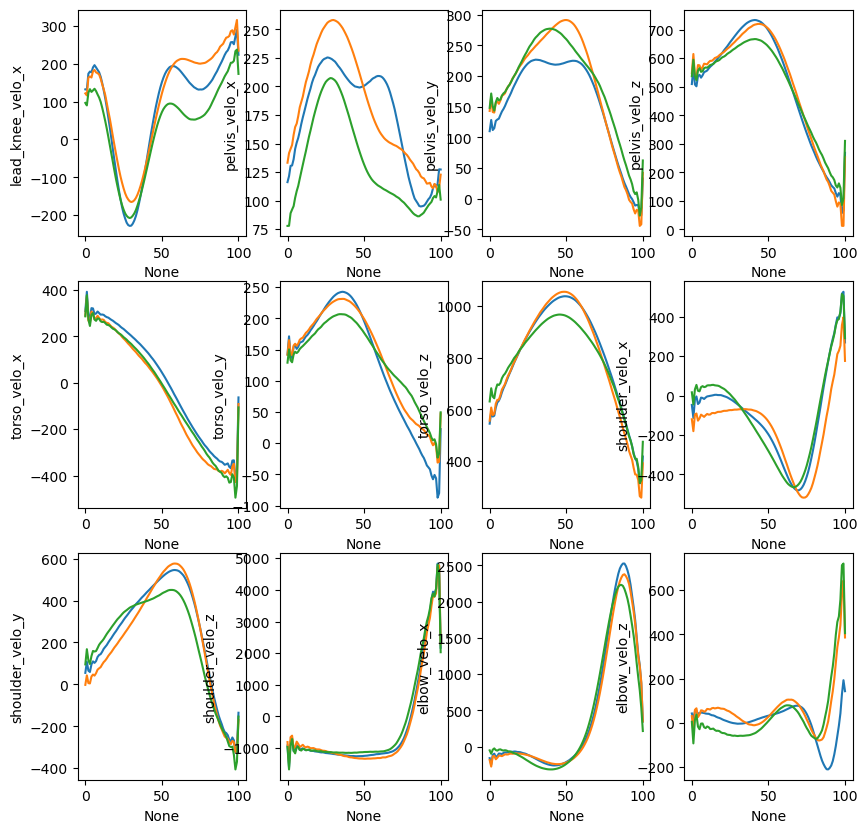

In [557]:
data_by_clusters = [cluster_1_averaged_data,
                    cluster_2_averaged_data,
                    cluster_3_averaged_data]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,10))

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="lead_knee_velo_x",
        ax=axs[0][0]
    )

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="pelvis_velo_x",
        ax=axs[0][1]
    )

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="pelvis_velo_y",
        ax=axs[0][2]
    )

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="pelvis_velo_z",
        ax=axs[0][3]
    )


for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="torso_velo_x",
        ax=axs[1][0]
    )

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="torso_velo_y",
        ax=axs[1][1]
    )

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="torso_velo_z",
        ax=axs[1][2]
    )

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="shoulder_velo_x",
        ax=axs[1][3]
    )

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="shoulder_velo_y",
        ax=axs[2][0]
    )

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="shoulder_velo_z",
        ax=axs[2][1]
    )

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="elbow_velo_x",
        ax=axs[2][2]
    )

for data in data_by_clusters:
    sns.lineplot(
        data=data,
        x=data.index, y="elbow_velo_z",
        ax=axs[2][3],
    )

In [558]:
# top 10 features based on F statistics
top_features

array(['elbow_velo_z_wrist_velo_x', 'elbow_velo_x_elbow_velo_z',
       'shoulder_velo_z_elbow_velo_z', 'torso_velo_x_elbow_velo_z',
       'lead_knee_velo_x_elbow_velo_z', 'shoulder_velo_y_elbow_velo_z',
       'shoulder_velo_x_elbow_velo_z', 'lead_knee_velo_x_torso_velo_z',
       'torso_velo_x_shoulder_velo_z', 'lead_knee_velo_x_shoulder_velo_x'],
      dtype=object)

In [559]:
def normlization(data):

    normalized_data = (data - min(data))/(max(data) - min(data))

    return normalized_data

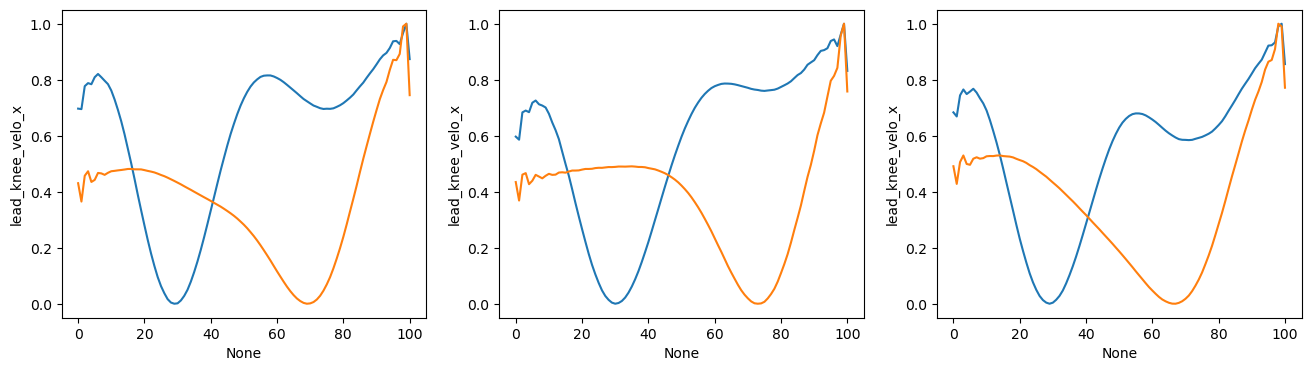

In [610]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))

for idx, data in enumerate(data_by_clusters):

    normalized = normlization(data["lead_knee_velo_x"])

    sns.lineplot(
        data=data,
        x=data.index, y=normalized,
        ax=axs[idx]
    )

    normalized = normlization(data["shoulder_velo_x"])

    sns.lineplot(
    data=data,
    x=data.index, y=normalized,
    ax=axs[idx]
    )


## Comparison of peak segmental velocity between clusters

In [ ]:
df_pint_velocity = df_point.filter(regex="vel")

In [562]:
df_pint_velocity

,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,lead_knee_extension_angular_velo_fp,lead_knee_extension_angular_velo_br,lead_knee_extension_angular_velo_max,max_cog_velo_x,max_pelvis_rotational_velo,cog_velo_pkh,timing_peak_torso_to_peak_pelvis_rot_velo
0,4533.2480,2445.8177,958.0878,160.4524,449.4070,452.7888,3.3113,609.9531,0.4643,0.0223
1,4571.1735,2389.5438,969.5766,300.1992,490.8747,513.3286,3.2385,639.6493,0.4367,0.0139
2,4165.3055,2426.3029,1090.2269,-176.7390,318.5102,333.5518,2.9110,881.1570,0.2008,0.0250
3,3832.1715,2424.0493,1105.2275,-48.8642,347.2241,350.0649,3.0930,905.8575,0.2679,0.0167
4,3970.7971,2497.6253,1110.4850,304.1101,434.3793,477.7753,3.0013,903.8906,0.2143,0.0139
...,...,...,...,...,...,...,...,...,...,...
406,4494.0446,2759.7142,1129.4168,-5.4738,198.2486,199.1849,2.8746,707.4018,0.3214,0.0222
407,4550.4618,2742.8536,1129.4417,64.8080,203.0749,203.0749,2.9474,683.6144,0.2722,0.0167
408,4580.0385,2796.3719,1133.8676,34.4653,219.9173,219.9173,2.9285,698.4257,0.2736,0.0167
409,4638.4414,2815.9331,1119.5235,73.1656,159.4130,224.8399,2.8382,709.9177,0.2321,0.0028


In [590]:
df_pint_velocity.loc["session"] = sessions.round(0)

In [596]:
point_velocity_by_pitchers = df_pint_velocity.groupby("session").mean().reset_index()
point_velocity_by_pitchers["session"] = point_velocity_by_pitchers["session"].astype(int)

In [598]:
df_merged = pd.merge(df_merged, point_velocity_by_pitchers, left_on="session", right_on="session")

In [607]:
df_merged.drop("index", axis=1)

colmuns = ["pitch_speed_mph", "elbow_varus_moment",
    "max_shoulder_internal_rotational_velo",
    "max_elbow_extension_velo",
    "max_elbow_extension_velo",
    "lead_knee_extension_angular_velo_max",
    "max_cog_velo_x",
    "max_pelvis_rotational_velo"]

df_merged.groupby("clusters")[colmuns].mean()

,pitch_speed_mph,elbow_varus_moment,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_elbow_extension_velo,lead_knee_extension_angular_velo_max,max_cog_velo_x,max_pelvis_rotational_velo
clusters,,,,,,,,
1,84.695145,116.451585,4477.106070,2505.377822,2505.377822,407.968835,3.081052,731.329852
2,85.755093,103.735925,4467.158061,2406.214122,2406.214122,346.870067,3.089956,743.801706
3,84.284737,105.327563,4477.563300,2463.318626,2463.318626,400.270484,2.986626,710.570884


In [612]:
df_merged = pd.merge(df_merged, df_feature_selection, left_on="session", right_on="session")

In [617]:
df_merged.drop(columns="clusters_y")

,session,clusters_x,index,session_mass_kg,session_height_m,age_yrs,playing_level,p_throw,pitch_speed_mph,elbow_varus_moment,...,shoulder_velo_z_elbow_velo_x,shoulder_velo_z_elbow_velo_z,shoulder_velo_z_wrist_velo_x,shoulder_velo_z_wrist_velo_y,elbow_velo_x_elbow_velo_z,elbow_velo_x_wrist_velo_x,elbow_velo_x_wrist_velo_y,elbow_velo_z_wrist_velo_x,elbow_velo_z_wrist_velo_y,wrist_velo_x_wrist_velo_y
0,1031,3,0,110.6784,1.9304,21.40,college,R,90.400000,142.860150,...,0.554531,0.382669,-0.864026,-0.351884,0.020153,-0.824426,-0.290773,-0.354737,0.089639,0.511308
1,1097,1,1,101.1528,1.9304,19.41,college,R,76.900000,132.920900,...,0.369810,-0.233619,-0.938446,-0.622314,-0.140554,-0.605771,-0.004098,0.075553,0.569656,0.488074
2,1170,1,2,82.1016,1.9304,20.52,college,R,81.750000,99.863650,...,0.496201,-0.344692,-0.809569,-0.396819,-0.456261,-0.815262,0.438975,0.518009,-0.130301,-0.023049
3,1313,1,3,84.3696,1.8288,19.02,college,R,85.833333,129.460833,...,0.256407,-0.080799,-0.912609,-0.293380,-0.090152,-0.383500,0.580011,-0.004904,0.334414,0.314956
4,1346,2,4,72.1224,1.8288,20.67,college,R,84.633333,84.773267,...,0.459465,0.221606,-0.903324,-0.238758,0.156448,-0.675891,0.254485,-0.172494,0.422562,0.121066
5,1403,3,5,70.3080,1.7780,19.10,college,R,78.400000,73.512367,...,0.417386,0.716099,-0.940083,-0.459161,0.150986,-0.683002,-0.392315,-0.641107,-0.372919,0.555530
6,1562,3,6,95.7096,1.8542,20.81,college,R,90.900000,119.651667,...,0.609561,0.624467,-0.856617,0.661895,0.201706,-0.671809,0.455546,-0.566188,0.722375,-0.390442
7,1574,3,7,87.0912,1.9304,21.22,college,R,89.300000,93.158567,...,0.388279,0.561880,-0.731882,0.014082,0.249151,-0.767078,0.695003,-0.687379,0.504551,-0.538048
8,1581,1,8,94.8024,1.7018,21.51,college,R,82.533333,118.285400,...,0.497883,-0.535770,-0.917884,-0.028874,-0.354454,-0.666619,0.533542,0.674855,0.417127,0.029935
9,1601,2,9,103.8744,1.8542,20.87,college,R,86.200000,135.216700,...,0.429964,-0.503078,-0.956007,0.264793,-0.180145,-0.439997,0.812217,0.408492,0.266609,-0.316643


## Prediction by features

In [626]:
from statsmodels.formula.api import ols

mod = ols("elbow_varus_moment ~ elbow_velo_z_wrist_velo_x + elbow_velo_x_elbow_velo_z + shoulder_velo_z_elbow_velo_z + torso_velo_x_elbow_velo_z + lead_knee_velo_x_elbow_velo_z + shoulder_velo_y_elbow_velo_z + shoulder_velo_x_elbow_velo_z + lead_knee_velo_x_torso_velo_z + torso_velo_x_shoulder_velo_z + lead_knee_velo_x_shoulder_velo_x", data=df_merged)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     elbow_varus_moment   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.265
Date:                Tue, 16 Sep 2025   Prob (F-statistic):              0.276
Time:                        00:22:59   Log-Likelihood:                -246.91
No. Observations:                  60   AIC:                             515.8
Df Residuals:                      49   BIC:                             538.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [643]:
featuers = ['elbow_velo_z_wrist_velo_x', 'elbow_velo_x_elbow_velo_z',
       'shoulder_velo_z_elbow_velo_z', 'torso_velo_x_elbow_velo_z',
       'lead_knee_velo_x_elbow_velo_z', 'shoulder_velo_y_elbow_velo_z',
       'shoulder_velo_x_elbow_velo_z', 'lead_knee_velo_x_torso_velo_z',
       'torso_velo_x_shoulder_velo_z', 'lead_knee_velo_x_shoulder_velo_x']

featuers.append("elbow_varus_moment")

df_merged[featuers].corr()

,elbow_velo_z_wrist_velo_x,elbow_velo_x_elbow_velo_z,shoulder_velo_z_elbow_velo_z,torso_velo_x_elbow_velo_z,lead_knee_velo_x_elbow_velo_z,shoulder_velo_y_elbow_velo_z,shoulder_velo_x_elbow_velo_z,lead_knee_velo_x_torso_velo_z,torso_velo_x_shoulder_velo_z,lead_knee_velo_x_shoulder_velo_x,elbow_varus_moment
elbow_velo_z_wrist_velo_x,1.000000,-0.907944,-0.960254,0.850563,-0.658657,0.639899,-0.722558,0.155843,-0.074981,0.131075,0.194915
elbow_velo_x_elbow_velo_z,-0.907944,1.000000,0.844466,-0.769533,0.658869,-0.491073,0.669980,-0.135932,0.103039,-0.223635,-0.250237
shoulder_velo_z_elbow_velo_z,-0.960254,0.844466,1.000000,-0.848126,0.651676,-0.742011,0.791789,-0.136861,0.033278,-0.080702,-0.211881
torso_velo_x_elbow_velo_z,0.850563,-0.769533,-0.848126,1.000000,-0.708336,0.483224,-0.504356,0.284619,-0.112086,0.048919,0.306960
lead_knee_velo_x_elbow_velo_z,-0.658657,0.658869,0.651676,-0.708336,1.000000,-0.355341,0.388640,-0.092633,0.021632,-0.198782,-0.221911
shoulder_velo_y_elbow_velo_z,0.639899,-0.491073,-0.742011,0.483224,-0.355341,1.000000,-0.637823,0.038145,0.087094,-0.030783,0.071903
shoulder_velo_x_elbow_velo_z,-0.722558,0.669980,0.791789,-0.504356,0.388640,-0.637823,1.000000,-0.093296,-0.038831,-0.060656,-0.110687
lead_knee_velo_x_torso_velo_z,0.155843,-0.135932,-0.136861,0.284619,-0.092633,0.038145,-0.093296,1.000000,0.131645,-0.387041,0.194747
torso_velo_x_shoulder_velo_z,-0.074981,0.103039,0.033278,-0.112086,0.021632,0.087094,-0.038831,0.131645,1.000000,-0.394315,-0.204727
lead_knee_velo_x_shoulder_velo_x,0.131075,-0.223635,-0.080702,0.048919,-0.198782,-0.030783,-0.060656,-0.387041,-0.394315,1.000000,0.115915


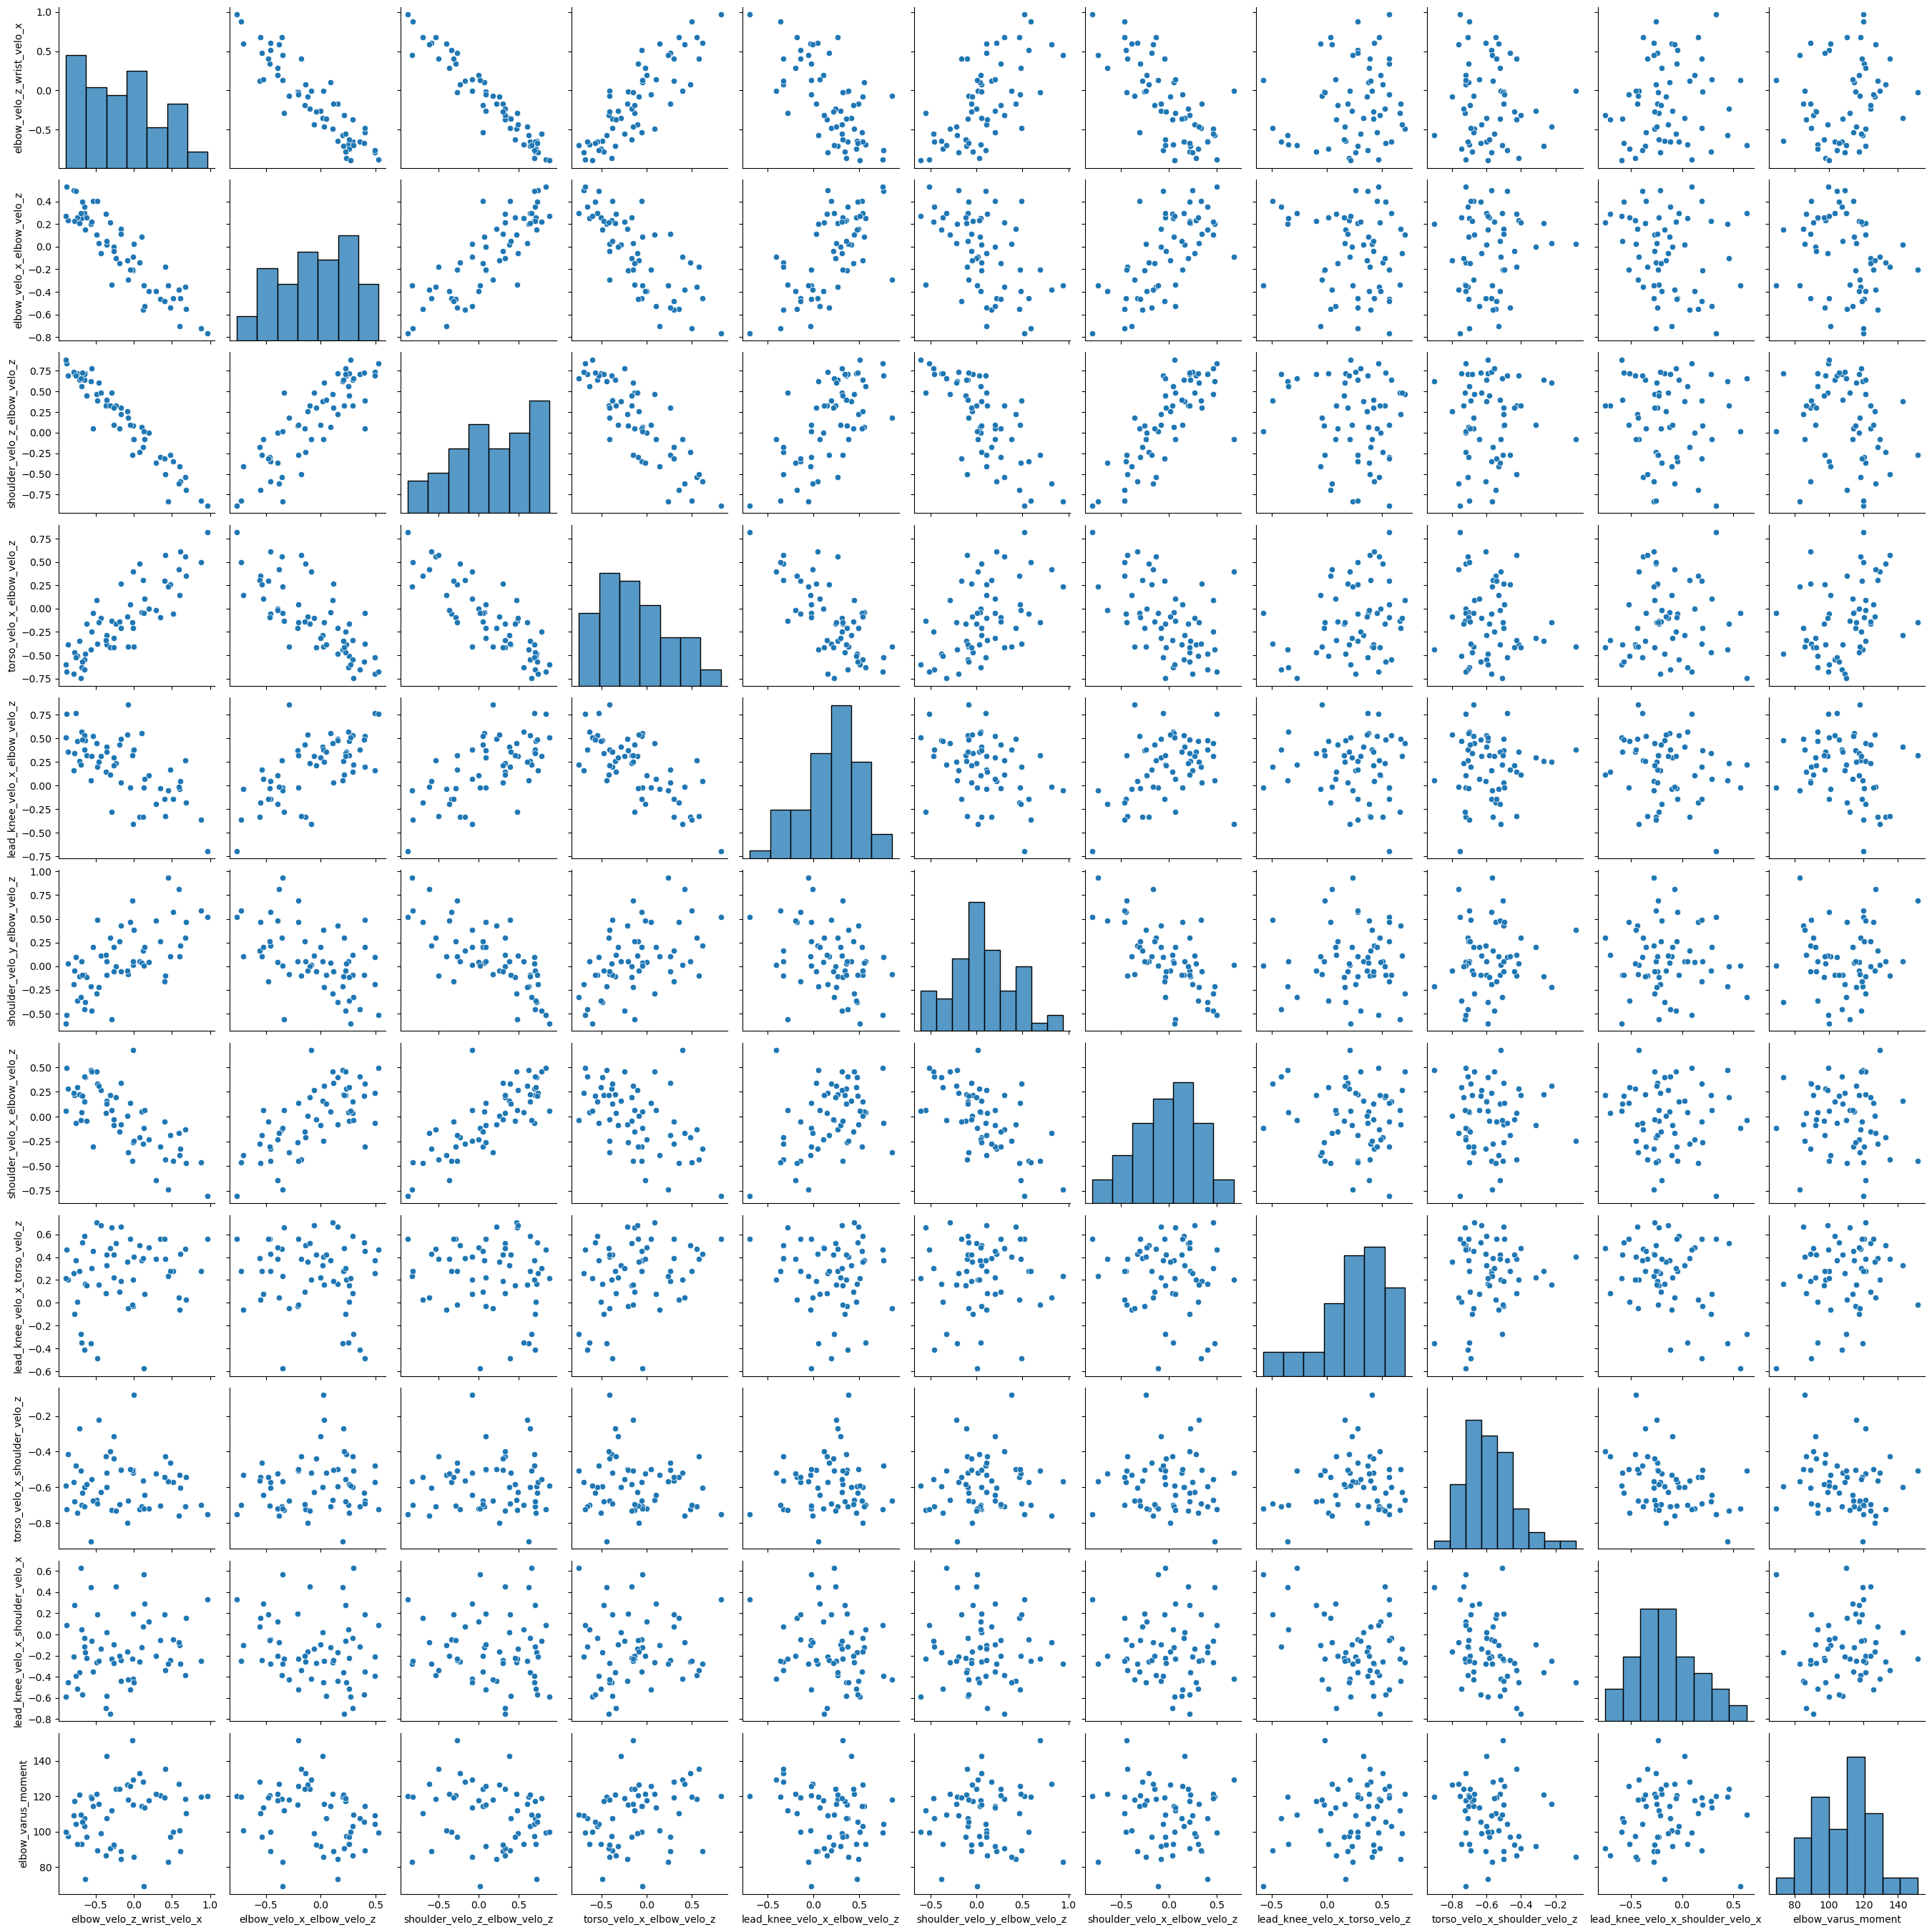

In [644]:
sns.pairplot(df_merged[featuers])